In [1]:
## CE 295 - Energy Systems and Control
# HW 5 : Optimal PHEV Energy Management via Dynamic Programming
# Franklin Zhao, SID 3033030808
# Prof. Moura
# Due Date Apr 13th

# BEAR_OSKI_HW5.ipynb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interp
import timeit
import seaborn as sns
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15

fs = 15 # Font Size for plots

In [2]:
## Parameters and Data

# Time step
Delta_t = 1.

# Fuel consumption in grams per unit energy
alph = 1e-4     # [g/(s-W)]

Qcap = 5*3600.        # [A-s = Coulombs]
V_oc = 330.             # [volts]

# Limits on Batt Power, Eng Power, SOC
P_batt_max = 15e3  # [W]
P_eng_max = 35e3   # [W]

SOC_min = 0.25     # [-]
SOC_max = 0.9      # [-]

## Load UDDS Data
data=pd.read_csv("UDDS_Pdem.csv")
print(data.head())
print(data.describe())

t = np.asarray(data)[:,0]
P_dem = np.asarray(data)[:,1]*1e3
v_dc = np.asarray(data)[:,2]

   Time (sec), t  Pwr Demand (kW), P_dem  Velocity (m/s), v_dc
0              0                     0.0                   0.0
1              1                     0.0                   0.0
2              2                     0.0                   0.0
3              3                     0.0                   0.0
4              4                     0.0                   0.0
       Time (sec), t  Pwr Demand (kW), P_dem  Velocity (m/s), v_dc
count    1370.000000             1370.000000           1370.000000
mean      684.500000                1.642977              8.751999
std       395.629246                6.904154              6.569676
min         0.000000              -15.000000              0.000000
25%       342.250000               -0.246054              2.604008
50%       684.500000                1.077528              9.656064
75%      1026.750000                5.474135             12.293600
max      1369.000000               29.703147             25.347168


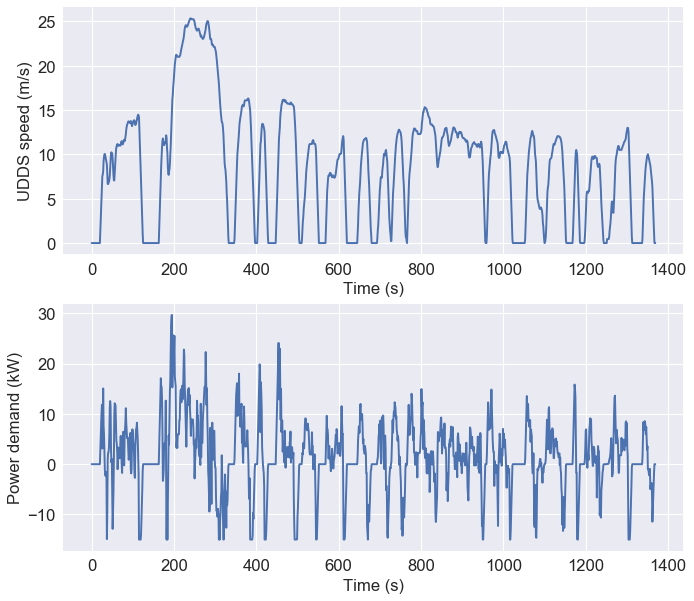

In [3]:
# Plot Power Demand Data
plt.figure(num=1, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, v_dc)  # plot speed
plt.ylabel('UDDS speed (m/s)')
plt.xlabel('Time (s)')

plt.subplot(2,1,2)
plt.plot(t, P_dem/1000) # plot power demand
plt.ylabel('Power demand (kW)')
plt.xlabel('Time (s)')

plt.show()

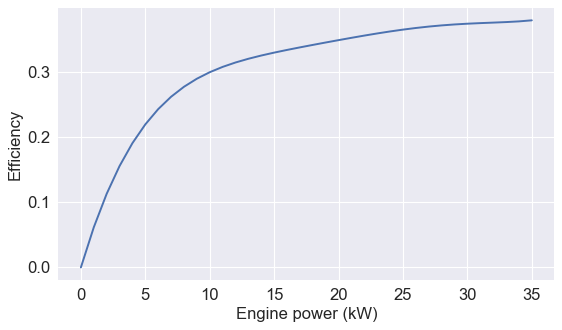

In [4]:
# ENGINE EFFICIENCY CURVE
def eta_eng(P_eng):

    # polynomial coefficients
    p1 =   5.128e-08
    p2 =  -5.927e-06
    p3 =   0.0002652
    p4 =    -0.00583
    p5 =      0.0672
    p6 =   2.622e-05

    # Convert from W to kW
    x = P_eng/1e3

    # Compute efficiency curve
    out = p1*x**5 + p2*x**4 + p3*x**3 + p4*x**2 + p5*x + p6
    return out

# Plot Engine efficiency Curve

plt.figure(num=2, figsize=(8, 4.5), dpi=80, facecolor='w', edgecolor='k')

P_eng = np.arange(P_eng_max/1000+1)
plt.plot(P_eng, eta_eng(P_eng * 1000)) # plot efficiency versus engine power, for total range of engine powers
plt.xlabel('Engine power (kW)')
plt.ylabel('Efficiency')

plt.show()

In [5]:
## Grid State Space and Preallocate arrays
SOC_grid = np.linspace(SOC_min,SOC_max,72)

# Grid size
ns = len(SOC_grid)  # No. of states

# Planning horizon (time steps)
N = len(t)

# Preallocate Value Function (rows index state, columns index time)
V = np.inf*np.ones((ns,N+1))

# Preallocate Control (rows index state, columns index time)
u_star = np.zeros((ns,N))

In [6]:
## SOLVE DYNAMIC PROGRAM
start = timeit.timeit()

# Boundary Condition of Value Function (Principle of Optimality)
V[:,N] = 0

# Iterate backward in time
for k in range(N-1, -1, -1):

    # Iterate over SOC
    for idx in range(0,ns):
        
        # Find dominant bounds for P_batt
        lb = max(-P_batt_max, Qcap * V_oc / Delta_t * (SOC_grid[idx]-SOC_max), P_dem[k] - P_eng_max)
        ub = min(P_batt_max, Qcap * V_oc / Delta_t * (SOC_grid[idx]-SOC_min), P_dem[k])
        
        # Grid Battery Power between dominant bounds
        P_batt_grid = np.linspace(lb,ub,200)
        
        # Compute engine power (vectorized for all P_batt_grid)
        P_eng = -P_batt_grid + P_dem[k]
        
        # Cost-per-time-step, a.k.a. fuel consumed at each stage (vectorized for all P_batt_grid)
        g_k = alph * Delta_t / eta_eng(P_eng) * P_eng
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] - Delta_t / (Qcap * V_oc) * P_batt_grid
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = interp(SOC_nxt, SOC_grid, V[:,k+1])
        
        # Value Function (Principle of Optimality)
        V[idx,k] = min(g_k + V_nxt)
        ind = np.argmin(g_k + V_nxt)
        
        # Save Optimal Control
        u_star[idx,k] = P_batt_grid[ind]
        
# DP Timer
end = timeit.timeit()
print(str(end - start) + " seconds")

-0.0074200630188 seconds


In [7]:
## Simulate Results

# Preallocate
SOC_sim = np.zeros((N,))
P_batt_sim = np.zeros((N,))
P_eng_sim = np.zeros((N,))
J_sim = np.zeros((N,))

# Initialize
SOC_0 = 0.75# put initial SOC here!
SOC_sim[0] = SOC_0

# Simulate PHEV Dynamics
for k in range(0,(N-1)):
    
    # Use optimal battery power, for given SOC
    P_batt_sim[k] = interp(SOC_sim[k], SOC_grid, u_star[:, k])
    
    # Compute engine power
    P_eng_sim[k] = P_dem[k] - P_batt_sim[k]
    
    # Fuel Consumption
    J_sim[k] = alph * Delta_t / eta_eng(P_eng_sim[k]) * P_eng_sim[k]
    
    # Time-step SOC dynamics
    SOC_sim[k+1] = -Delta_t / (Qcap * V_oc) * P_batt_sim[k] + SOC_sim[k]

In [8]:
# Compute the result of Problem 7
# SOC_sim[-1], np.cumsum(J_sim)[-1]/1000

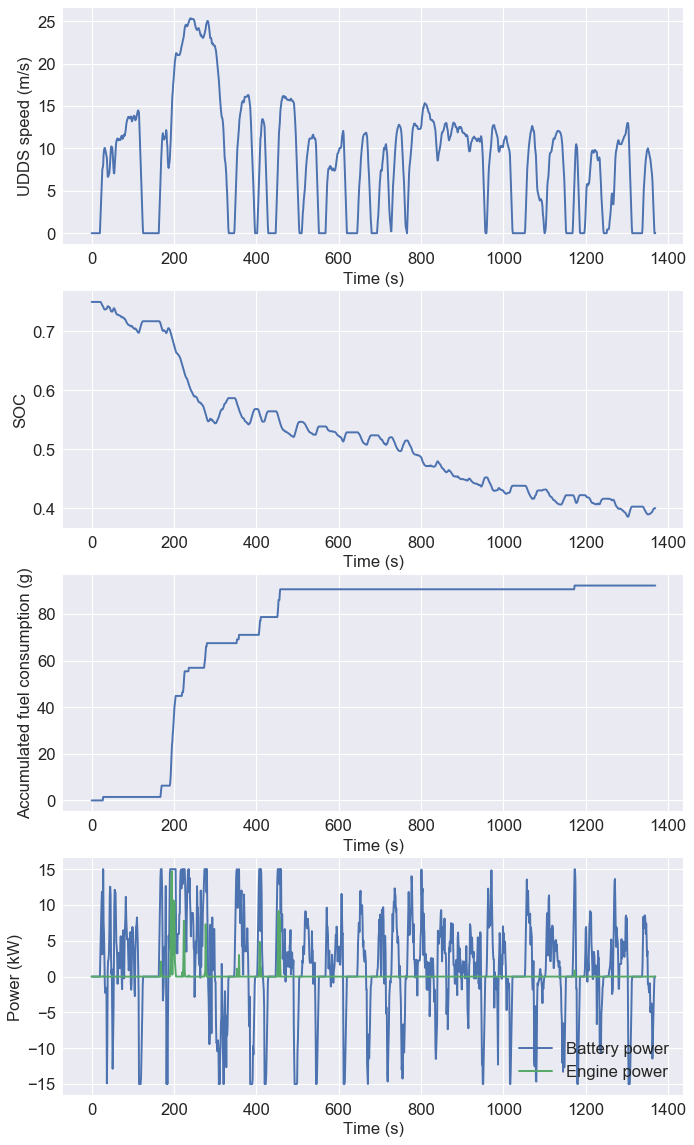

In [9]:
## Plot Simulation Results
plt.figure(num=4, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(4,1,1)
# UDDS speed versus time 
plt.plot(t, v_dc)
plt.ylabel('UDDS speed (m/s)')
plt.xlabel('Time (s)')

plt.subplot(4,1,2)
# SOC versus time
plt.plot(t, SOC_sim)
plt.ylabel('SOC')
plt.xlabel('Time (s)')

plt.subplot(4,1,3)
# Accumulated fuel consumption [g] versus time
plt.plot(t, np.cumsum(J_sim))
plt.ylabel('Accumulated fuel consumption (g)')
plt.xlabel('Time (s)')

plt.subplot(4,1,4)
# Battery and engine power [kW] versus time
plt.plot(t, P_batt_sim/1000, label='Battery power')
plt.plot(t, P_eng_sim/1000, label='Engine power')
plt.legend()
plt.ylabel('Power (kW)')
plt.xlabel('Time (s)')

plt.show()